In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions


../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"
import pandas as pd

import os

def make_and_store_predictions(model, x, date, N_seen_points=250, N_predictions=50, ylim=None, device=torch.device('cpu'), store=None, meanstd=None, title=""):
    os.makedirs(os.path.dirname(store),exist_ok=True)

    future = x.shape[0] - N_seen_points

    x_ = torch.Tensor(x)[None, :].to(device)
    if x_.shape[2] == 2:
        doy_seen = x_[:, :N_seen_points, 1]
        doy_future = x_[:, N_seen_points:, 1]
    else:
        doy_seen = None
        doy_future=None
    x_data = x_[:, :N_seen_points, 0].unsqueeze(2)

    mean, epi_var, ale_var,y_hat = model.predict(x_data, N_predictions, future, date=doy_seen, date_future=doy_future, return_yhat=True)
    var = epi_var + ale_var

    mean = mean.cpu().squeeze()
    var = var.cpu().squeeze()
    epi_var = epi_var.cpu().squeeze()
    ale_var = ale_var.cpu().squeeze()

    epi_std = torch.sqrt(epi_var[1:])
    ale_std = torch.sqrt(ale_var[1:])
    data_std = epi_std + ale_std

    if meanstd is not None:
        dmean, dstd = meanstd
        x = (x * dstd) + dmean
        mean = (mean * dstd) + dmean
        y_hat = (y_hat * dstd) + dmean
        ale_std = ale_std * dstd
        epi_std = epi_std * dstd
        data_std = data_std * dstd

    n_sigma = 1
    
    #for y_pred in y_hat:
    #    label = "prediction" if idx == 0 else None
    #    ax.plot(date[:N_seen_points + future], y_pred, c=tumorange, label=label, alpha=(1 / N_predictions) ** 0.7)

    
    df = pd.DataFrame([date, mean.numpy(), epi_std.numpy(), ale_std.numpy(), data_std.numpy(), x[:, 0]],
                 index=["date", "mean", "epi_std", "ale_std", "std", "x"]).T
    df["mean-epistd"] = df["mean"] - df["epi_std"]
    df["mean+epistd"] = df["mean"] + df["epi_std"]
    df["mean-alestd"] = df["mean"] - df["ale_std"]
    df["mean+alestd"] = df["mean"] + df["ale_std"]
    df["mean-std"] = df["mean"] - df["std"]
    df["mean+std"] = df["mean"] + df["std"]
    df.iloc[:N_seen_points].to_csv(f"{store}_seen.csv")
    df.iloc[N_seen_points:].to_csv(f"{store}_predicted.csv")
    df.to_csv(f"{store}.csv")
    print(f"saving to {store}")

    preds = pd.DataFrame(y_hat.squeeze().cpu().numpy(), index=[f"pred{run}" for run in range(N_predictions)]).T
    preds["date"] = date
    preds.to_csv(f"{store}_predictions.csv")


In [55]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 3
hidden_size = 32
region = "germany"#"volcanopuyehue" #"germany"
epochs = 100
include_time = False
smooth = None
use_attention = True

model_dir="/data2/igarss2020/models/"
log_dir = "/data2/igarss2020/models/"
name_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}"
log_pattern = "LSTM_{region}_l={num_layers}_h={hidden_size}"


remove_seasonality = False

dataset = ModisDataset(region=region,
                       fold="train",
                       znormalize=True,
                       augment=True,
                       overwrite=False,
                       include_time=include_time,
                       filter_date=(None,"2010-01-01"),
                       remove_seasonality=remove_seasonality,
                       smooth=smooth)

validdataset = ModisDataset(region=region,
                            fold="validate",
                            znormalize=True,
                            znormalize_with_meanstd=(dataset.mean, dataset.std),
                            augment=False,
                            filter_date=(None, None),
                            include_time=include_time,
                            remove_seasonality=remove_seasonality,
                            smooth=smooth)

testdataset = ModisDataset(region=region,
                            fold="test",
                            znormalize=True,
                            znormalize_with_meanstd=(dataset.mean, dataset.std),
                            augment=False,
                            filter_date=(None, None),
                            include_time=include_time,
                            remove_seasonality=remove_seasonality,
                            smooth=smooth)


dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=512,
                                         shuffle=True,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )
validdataloader = torch.utils.data.DataLoader(validdataset,
                                         batch_size=512,
                                         shuffle=False,
                                         #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                         )

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

model = Model(input_size=1,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              dropout=0.5,
              device=device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)


running_idx = 0
steps = 10
for epoch in range(1):

    for idx, batch in enumerate(dataloader):
        model.train()
        model.dropout.eval()
        
        x_data, y_true = batch

        optimizer.zero_grad()
        y_pred, log_variances = model(x_data.to(device))
        loss = criterion(y_pred, y_true.to(device), log_variances)
        loss.backward()
        optimizer.step()

        if idx % steps == 0:
            fid = 1
            x = testdataset.data[fid].astype(float)
            date = testdataset.date[fid].astype(np.datetime64)

            model.dropout.train()
            make_and_store_predictions(model, x, date, N_seen_points=227, N_predictions=50,
                                      device=device,meanstd=(dataset.mean,dataset.std), store=f"/tmp/{fid}/{running_idx}")
            running_idx += steps
        
    #test_model(model, validdataset, device, title=f"                 epoch {epoch}")



local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
5694.5619659690865 2287.9871312288965
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5694.5619659690865 2287.9871312288965
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
5694.5619659690865 2287.9871312288965
saving to /tmp/1/0
saving to /tmp/1/10
saving to /tmp/1/20
saving to /tmp/1/30
saving to /tmp/1/40
saving to /tmp/1/50
saving to /tmp/1/60
saving to /tmp/1/70
saving to /tmp/1/80
saving to /tmp/1/90
saving to /tmp/1/100
saving to /tmp/1/110
saving to /tmp/1/120
saving to /tmp/1/130
saving to /tmp/1/140
saving to /tmp/1/150
saving to /tmp/1/160
saving to /tmp/1/170
saving to /tmp/1/180
saving to /tmp/1/190
saving to /tmp/1/200
saving to /tmp/1/210
saving to /tmp/1/220


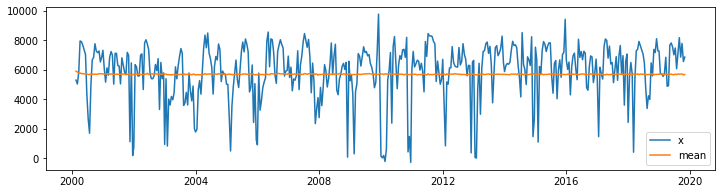

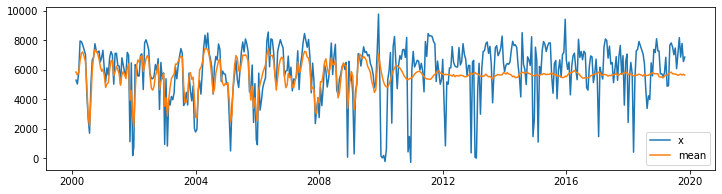

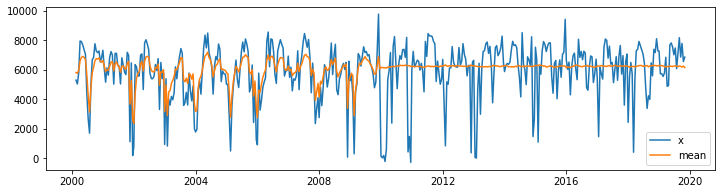

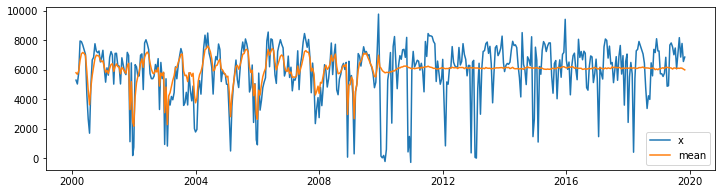

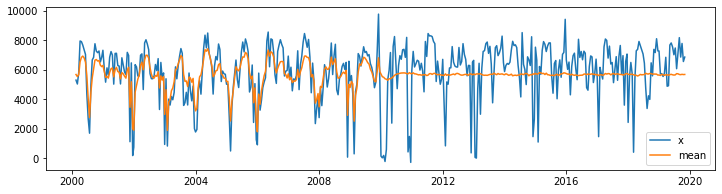

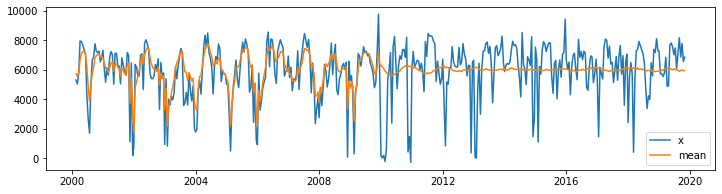

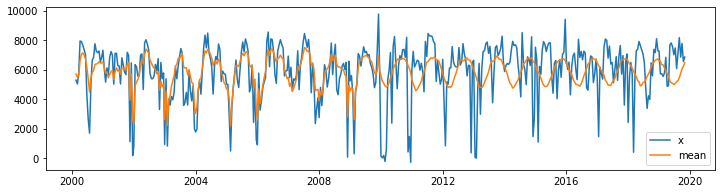

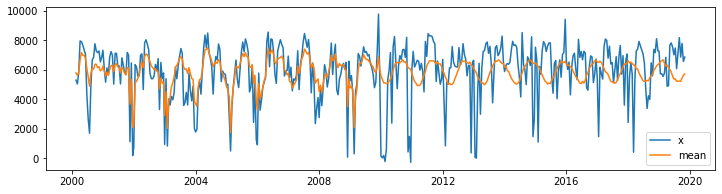

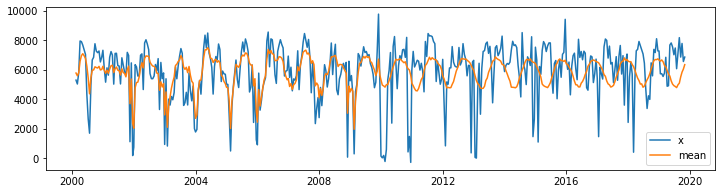

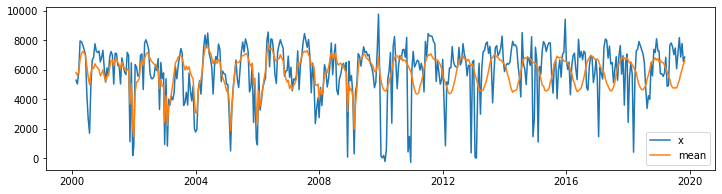

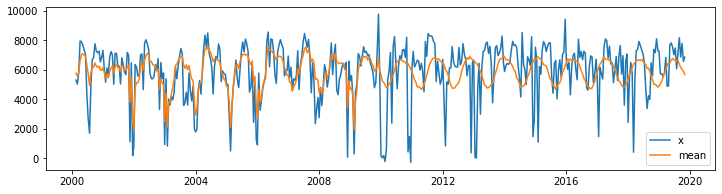

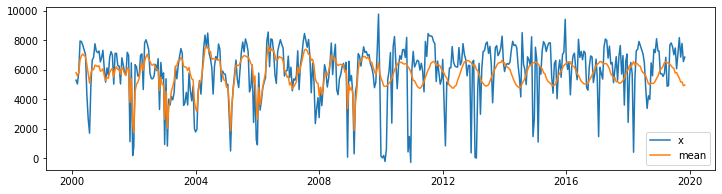

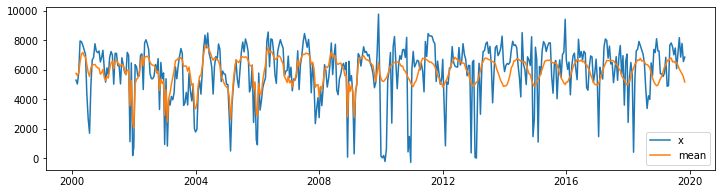

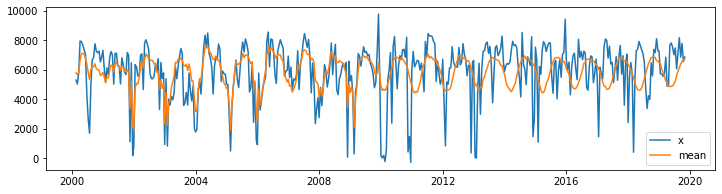

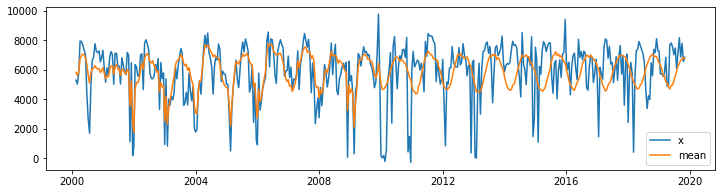

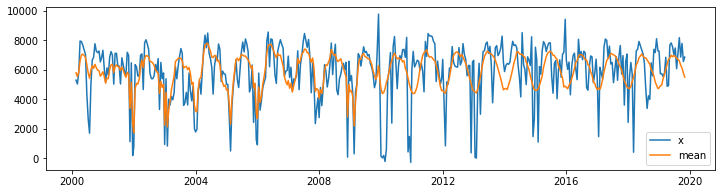

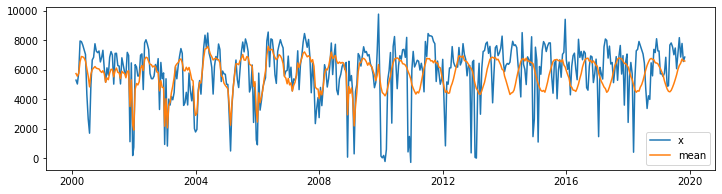

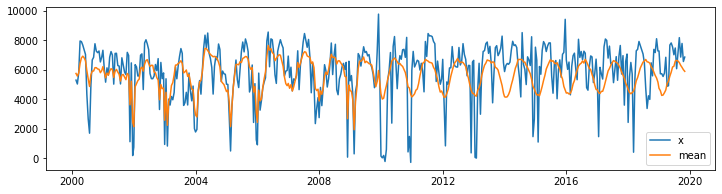

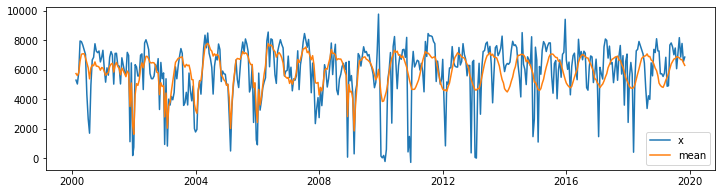

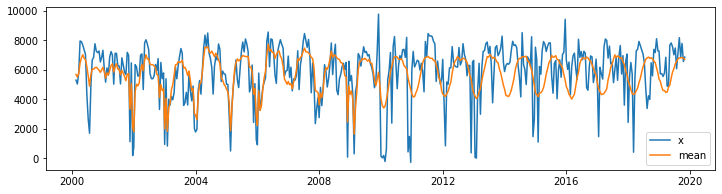

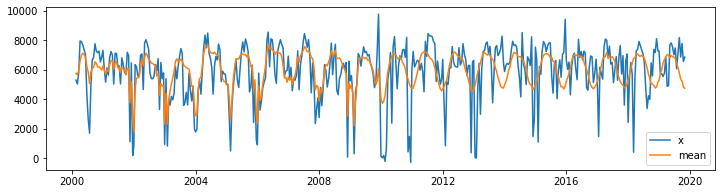

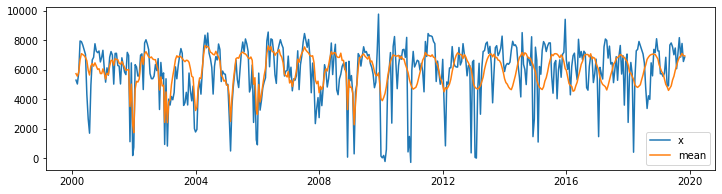

In [60]:
directory = "/tmp/anim"
!mkdir /tmp/anim

for i in range(22):
    df = pd.read_csv(f"/tmp/1/{i*10}.csv", index_col=0).dropna()
    df["date"] = pd.to_datetime(df["date"])
    df.set_index("date", inplace=True)

    fig,ax = plt.subplots(figsize=(12,3))
    ax.plot(df["x"], label="x")
    ax.plot(df["mean"], label="mean")
    ax.legend()
    
    fig.savefig(directory+f"/{i:03d}.png")

    plt.pause(.1)

In [ ]:
!ffmpeg -r 30 -f image2 -s 1920x1080 -i "/tmp/anim/%03d.png" -vcodec libx264 -crf 25  -pix_fmt yuv420p /tmp/anim.mp4


ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('/tmp/anim.mp4', 'r+b').read()
encoded = base64.b64encode(video)

HTML(data='''<video alt="test" controls>
<source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''.format(encoded.decode('ascii')))

In [10]:
def load_and_plot_predictions(store=None):

    future = x.shape[0] - N_seen_points

    fig, axs = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(title)
    axs = np.array(axs).reshape(-1)

    axs[0].set_title("epistemic uncertainty")
    axs[1].set_title("aleatoric uncertainty")
    axs[2].set_title("combined uncertainty")


    n_sigma = 1
    axs[0].fill_between(date[1:], mean[1:] + epi_std, mean[1:] - epi_std,
                        alpha=.5, label=f"epistemic {n_sigma}" + r"$\sigma$")
    axs[1].fill_between(date[1:], mean[1:] + ale_std, mean[1:] - ale_std,
                        alpha=.5, label=f"aleatoric {n_sigma}" + r"$\sigma$")
    axs[2].fill_between(date[1:], mean[1:] + data_std, mean[1:] - data_std, alpha=.5,
                        label=r"combined $\sigma$")

    for ax in axs:
        ax.plot(date[:N_seen_points], x[:N_seen_points, 0], c="#000000", alpha=1, label="seen input sequence")
        ax.plot(date[N_seen_points:], x[N_seen_points:, 0], c="#000000", alpha=.1, label="unseen future")
        if N_seen_points < len(date):
            ax.axvline(x=date[N_seen_points], ymin=0, ymax=1)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.plot(date[1:], mean[1:],c=tumorange)

    #for y_pred in y_hat:
    #    label = "prediction" if idx == 0 else None
    #    ax.plot(date[:N_seen_points + future], y_pred, c=tumorange, label=label, alpha=(1 / N_predictions) ** 0.7)

    [ax.legend(ncol=3) for ax in axs]

    if store is not None:
        import pandas as pd
        df = pd.DataFrame([date, mean.numpy(), epi_std.numpy(), ale_std.numpy(), data_std.numpy(), x[:, 0]],
                     index=["date", "mean", "epi_std", "ale_std", "std", "x"]).T
        df["mean-epistd"] = df["mean"] - df["epi_std"]
        df["mean+epistd"] = df["mean"] + df["epi_std"]
        df["mean-alestd"] = df["mean"] - df["ale_std"]
        df["mean+alestd"] = df["mean"] + df["ale_std"]
        df["mean-std"] = df["mean"] - df["std"]
        df["mean+std"] = df["mean"] + df["std"]
        df.iloc[:N_seen_points].to_csv(f"{store}_seen.csv")
        df.iloc[N_seen_points:].to_csv(f"{store}_predicted.csv")
        df.to_csv(f"{store}.csv")
        print(f"saving to {store}")
        
        preds = pd.DataFrame(y_hat.squeeze().cpu().numpy(), index=[f"pred{run}" for run in range(N_predictions)]).T
        preds["date"] = date
        preds.to_csv(f"{store}_predictions.csv")

    return fig, axs


0.csv		     250_predictions.csv  50.csv
0_predicted.csv      250_seen.csv	  50_predicted.csv
0_predictions.csv    300.csv		  50_predictions.csv
0_seen.csv	     300_predicted.csv	  50_seen.csv
100.csv		     300_predictions.csv  550.csv
100_predicted.csv    300_seen.csv	  550_predicted.csv
100_predictions.csv  350.csv		  550_predictions.csv
100_seen.csv	     350_predicted.csv	  550_seen.csv
150.csv		     350_predictions.csv  600.csv
150_predicted.csv    350_seen.csv	  600_predicted.csv
150_predictions.csv  400.csv		  600_predictions.csv
150_seen.csv	     400_predicted.csv	  600_seen.csv
1.csv		     400_predictions.csv  650.csv
1_predicted.csv      400_seen.csv	  650_predicted.csv
1_predictions.csv    450.csv		  650_predictions.csv
1_seen.csv	     450_predicted.csv	  650_seen.csv
200.csv		     450_predictions.csv  700.csv
200_predicted.csv    450_seen.csv	  700_predicted.csv
200_predictions.csv  500.csv		  700_predictions.csv
200_seen.csv	     500_predicted.csv	  700_seen.csv
250.csv		   